[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/maplightrx/MapLight-TDC/blob/main/submission_gnn.ipynb)

__WARNING__: This notebook is not runnable on Colab because of [this issue](https://github.com/datamol-io/molfeat/issues/61). Please run it locally.

In [ ]:
!curl -o maplight_gnn.py https://raw.githubusercontent.com/maplightrx/MapLight-TDC/main/maplight_gnn.py

In [3]:
# installs for Colab
!conda run -n maplight pip install rdkit PyTDC tqdm catboost python-dotenv molfeat transformers torch_geometric dgl dgllife

  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached pandas-2.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached scikit_learn-1.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached torch-2.4.1-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached matplotlib-3.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
Using cached pandas-2.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.0 MB)
Using cached torch-2.4.1-cp310-cp310-manylinux1_x86_64.whl (797.1 MB)
Using cached matplotlib-3.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.3 MB)
  Attempting uninstall: numpy
    Foun

In [2]:
!conda run -n maplight pip install scipy h5py

In [19]:
from maplight_gnn import *
from tqdm import tqdm
import catboost as cb

from tdc.benchmark_group import admet_group

/shared/miniconda3/envs/maplight/lib/python3.10/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


In [32]:
from tdc.utils import create_scaffold_split, create_fold
import pandas as pd
df_tox = pd.read_csv('/efs-private/alladmet/tox21/tox21_hek293_combined_assays.csv')
tox_data = {}
frac = frac = [0.875, 0.125, 0.0]
def canonicalize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    canonical_smiles = Chem.MolToSmiles(mol, canonical=True)
    return canonical_smiles
df_tox['smiles'] = df_tox.smiles.map(canonicalize_smiles)
for column in df_tox.columns[4:]:
    dataset = df_tox[['smiles',column]].rename(columns={'smiles':"Drug", column:"Y"}).dropna()
    #train, test, _ = create_scaffold_split(dataset, 42,frac, 'DRUG')
    folds = create_fold(dataset, 42, frac)
    data = {
        'name': column,
        'train_val': folds['train'],
        'test': folds['valid']
    }
    tox_data[column] = data
tox_data

{'tox21-ar-bla-agonist-p1': {'name': 'tox21-ar-bla-agonist-p1',
  'train_val':                                                    Drug    Y
  0     C[N+]1(C)[C@@H]2CC[C@H]1C[C@@H](OC(=O)C(CO)c1c...  0.0
  1     C[N+]1([O-])[C@@H]2CC[C@H]1C[C@@H](OC(=O)C(CO)...  0.0
  2                                         O=C(O)C1CCCN1  0.0
  3                    CN(C)CCCN1c2ccccc2C(C)(C)c2ccccc21  0.0
  4     CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...  0.0
  ...                                                 ...  ...
  6920     CC(=O)CCC(=O)[O-].CC(=O)CCC(=O)[O-].O.O.[Ca+2]  0.0
  6921  O=C(Nc1ccc(S(=O)(=O)N2CCOCC2)cc1)c1cc(Cl)ccc1N...  0.0
  6922                                       NC(CS)C(=O)O  0.0
  6923  CC(=O)Oc1ccc2c(c1)CC[C@@H]1[C@@H]2CC[C@]2(C)[C...  1.0
  6924                                COC(=O)C(Cl)C(=O)OC  0.0
  
  [6925 rows x 2 columns],
  'test':                                                   Drug    Y
  0              CCOC(=O)c1ncn2c1CN(C)C(=O)c1c(I)cccc1-2  0.0
  1  

In [53]:
benchmark_config2 = {k:('binary',False) for k in tox_data}
benchmark_config2

{'tox21-ar-bla-agonist-p1': ('binary', False),
 'tox21-ar-bla-antagonist-p1': ('binary', False),
 'tox21-elg1-luc-agonist-p1': ('binary', False),
 'tox21-er-bla-agonist-p2': ('binary', False),
 'tox21-er-bla-antagonist-p1': ('binary', False),
 'tox21-erb-bla-antagonist-p1': ('binary', False),
 'tox21-erb-bla-p1': ('binary', False),
 'tox21-err-p1_agonist': ('binary', False),
 'tox21-fxr-bla-agonist-p2': ('binary', False),
 'tox21-fxr-bla-antagonist-p1': ('binary', False),
 'tox21-pgc-err-p1_agonist': ('binary', False),
 'tox21-ppard-bla-agonist-p1': ('binary', False),
 'tox21-ppard-bla-antagonist-p1': ('binary', False),
 'tox21-pparg-bla-agonist-p1': ('binary', False),
 'tox21-pparg-bla-antagonist-p1': ('binary', False),
 'tox21-pr-bla-agonist-p1': ('binary', False),
 'tox21-pr-bla-antagonist-p1': ('binary', False),
 'tox21-rt-viability-hek293-p1_glo 8 hr': ('binary', False),
 'tox21-rt-viability-hek293-p1_glo 40 hr': ('binary', False),
 'tox21-rt-viability-hek293-p1_flor 16 hr': ('bin

In [253]:
group = admet_group(path = 'data/')
group.get('caco2_wang')

Found local copy...


{'train_val':                          Drug_ID  \
 0                        H 95/71   
 1                       H 244/45   
 2           D-Phe-D-Ala-D-Ser-OH   
 3                 Dexloxiglumide   
 4                   Ac-D-phe-NH2   
 ..                           ...   
 723                           11   
 724                  Gancyclovir   
 725                      Val-ACV   
 726  1033-Dextromethorphan (DEM)   
 727             Dextromethorphan   
 
                                                   Drug         Y  
 0                          CC(C)NCC(O)COc1ccc(NC=O)cc1 -5.427984  
 1                      CCC(=O)Nc1ccc(OCC(O)CNC(C)C)cc1 -5.219842  
 2    C[C@H](NC(=O)[C@H](N)Cc1ccccc1)C(=O)N[C@H](CO)... -6.281999  
 3    CCCCCN(CCCOC)C(=O)[C@@H](CCC(=O)O)NC(=O)c1ccc(... -5.140131  
 4                       CC(=O)N[C@@H](Cc1ccccc1)C(N)=O -5.100090  
 ..                                                 ...       ...  
 723  CCCCCCC(N)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N1CCC... -5.790000

In [16]:
benchmark_config = {
    'caco2_wang': ('regression', False),
    'bioavailability_ma': ('binary', False),
    'lipophilicity_astrazeneca': ('regression', False),
    'solubility_aqsoldb': ('regression', False),
    'hia_hou': ('binary', False),
    'pgp_broccatelli': ('binary', False),
    'bbb_martins': ('binary', False),
    'ppbr_az': ('regression', False),
    'vdss_lombardo': ('regression', True),
    'cyp2c9_veith': ('binary', False),
    'cyp2d6_veith': ('binary', False),
    'cyp3a4_veith': ('binary', False),
    'cyp2c9_substrate_carbonmangels': ('binary', False),
    'cyp2d6_substrate_carbonmangels': ('binary', False),
    'cyp3a4_substrate_carbonmangels': ('binary', False),
    'half_life_obach': ('regression', True),
    'clearance_hepatocyte_az': ('regression', True),
    'clearance_microsome_az': ('regression', True),
    'ld50_zhu': ('regression', False),
    'herg': ('binary', False),
    'ames': ('binary', False),
    'dili': ('binary', False)
}

In [52]:
#group = admet_group(path = 'data/')
group = tox_data

# change comment to run all benchmarks
# for admet_benchmark in benchmark_config.keys():
for admet_benchmark in list(benchmark_config.keys()):
    predictions_list = []
    for seed in tqdm([1, 2, 3, 4, 5]):
        benchmark = group.get(admet_benchmark)
        predictions = {}
        name = benchmark['name']
        train, test = benchmark['train_val'], benchmark['test']

        # --------------------------------------------- # 
        #  Train your model using train, valid, test    #
        #  Save test prediction in y_pred_test variable #
        X_train = get_fingerprints(train['Drug'])
        X_test = get_fingerprints(test['Drug'])

        task, log_scale = benchmark_config[name]
        params = {
                'random_strength': 2, 
                'random_seed': seed,
                'verbose': 0,
            }

        if task == 'regression':
            Y_scaler = scaler(log=log_scale)
            Y_scaler.fit(train['Y'].values)
            train['Y_scale'] = Y_scaler.transform(train['Y'].values)

            params['loss_function'] = 'MAE'            
            model = cb.CatBoostRegressor(**params)
            model.fit(X_train, train['Y_scale'].values)

            y_pred_test = Y_scaler.inverse_transform(model.predict(X_test)).reshape(-1)
        elif task == 'binary':
            params['loss_function'] = 'Logloss'
            model = cb.CatBoostClassifier(**params)
            model.fit(X_train, train['Y'].values)

            y_pred_test = model.predict_proba(X_test)[:, 1]
            
        # --------------------------------------------- #
        model.save_model(f"{name}")
        predictions[name] = y_pred_test
        predictions_list.append(predictions)
    
    #results = group.evaluate_many(predictions_list)
    results = evaluate_many(predictions_list)
    print('\n\n{}'.format(results))

100%|████████████████████████████████████████████| 5/5 [09:38<00:00, 115.77s/it]




{'tox21-ar-bla-agonist-p1': 0.6697058013124764}


100%|████████████████████████████████████████████| 5/5 [09:36<00:00, 115.36s/it]




{'tox21-ar-bla-antagonist-p1': 0.6595399594606959}


100%|████████████████████████████████████████████| 5/5 [09:39<00:00, 115.91s/it]




{'tox21-elg1-luc-agonist-p1': 0.40108834160043505}


100%|████████████████████████████████████████████| 5/5 [09:39<00:00, 115.86s/it]




{'tox21-er-bla-agonist-p2': 0.6092106680858784}


100%|████████████████████████████████████████████| 5/5 [09:41<00:00, 116.23s/it]




{'tox21-er-bla-antagonist-p1': 0.4823086518234406}


100%|████████████████████████████████████████████| 5/5 [08:40<00:00, 104.15s/it]




{'tox21-erb-bla-antagonist-p1': 0.6929413407664058}


100%|████████████████████████████████████████████| 5/5 [08:37<00:00, 103.47s/it]




{'tox21-erb-bla-p1': 0.5721354753252659}


100%|████████████████████████████████████████████| 5/5 [08:39<00:00, 103.85s/it]




{'tox21-err-p1_agonist': 0.5580274475980325}


100%|████████████████████████████████████████████| 5/5 [08:22<00:00, 100.42s/it]




{'tox21-fxr-bla-agonist-p2': 0.11573660989290988}


100%|████████████████████████████████████████████| 5/5 [08:27<00:00, 101.56s/it]




{'tox21-fxr-bla-antagonist-p1': 0.615968136771383}


100%|████████████████████████████████████████████| 5/5 [08:45<00:00, 105.19s/it]




{'tox21-pgc-err-p1_agonist': 0.539959600363187}


100%|████████████████████████████████████████████| 5/5 [08:23<00:00, 100.77s/it]




{'tox21-ppard-bla-agonist-p1': 0.19625407145149784}


100%|████████████████████████████████████████████| 5/5 [08:28<00:00, 101.75s/it]




{'tox21-ppard-bla-antagonist-p1': 0.5632711688060781}


100%|████████████████████████████████████████████| 5/5 [09:36<00:00, 115.27s/it]




{'tox21-pparg-bla-agonist-p1': 0.2525699242654938}


100%|████████████████████████████████████████████| 5/5 [08:26<00:00, 101.32s/it]




{'tox21-pparg-bla-antagonist-p1': 0.5289548035490031}


100%|████████████████████████████████████████████| 5/5 [08:36<00:00, 103.34s/it]




{'tox21-pr-bla-agonist-p1': 0.7899663652485656}


100%|████████████████████████████████████████████| 5/5 [08:41<00:00, 104.37s/it]




{'tox21-pr-bla-antagonist-p1': 0.7362243436400906}


100%|████████████████████████████████████████████| 5/5 [08:40<00:00, 104.05s/it]




{'tox21-rt-viability-hek293-p1_glo 8 hr': 0.5969980065413225}


100%|████████████████████████████████████████████| 5/5 [08:38<00:00, 103.74s/it]




{'tox21-rt-viability-hek293-p1_glo 40 hr': 0.6576005331594735}


100%|████████████████████████████████████████████| 5/5 [08:37<00:00, 103.55s/it]




{'tox21-rt-viability-hek293-p1_flor 16 hr': 0.38014322719477994}


100%|████████████████████████████████████████████| 5/5 [08:37<00:00, 103.46s/it]




{'tox21-rt-viability-hek293-p1_flor 24 hr': 0.4804392704504298}


100%|████████████████████████████████████████████| 5/5 [08:39<00:00, 103.86s/it]




{'tox21-rt-viability-hek293-p1_flor 32 hr': 0.5082616310391517}


100%|████████████████████████████████████████████| 5/5 [08:44<00:00, 104.85s/it]




{'tox21-rt-viability-hek293-p1_flor 40 hr': 0.48097666062743183}


100%|████████████████████████████████████████████| 5/5 [08:37<00:00, 103.54s/it]




{'tox21-rt-viability-hek293-p1_flor 0 hr': 0.1305805283547188}


100%|████████████████████████████████████████████| 5/5 [08:38<00:00, 103.71s/it]




{'tox21-rt-viability-hek293-p1_flor 8 hr': 0.41644268449488814}


100%|████████████████████████████████████████████| 5/5 [08:35<00:00, 103.15s/it]




{'tox21-rt-viability-hek293-p1_glo 0 hr': 0.3236972067706582}


100%|████████████████████████████████████████████| 5/5 [08:38<00:00, 103.61s/it]




{'tox21-rt-viability-hek293-p1_glo 16 hr': 0.5927310291767236}


100%|████████████████████████████████████████████| 5/5 [08:38<00:00, 103.78s/it]




{'tox21-rt-viability-hek293-p1_glo 24 hr': 0.6721383226915384}


100%|████████████████████████████████████████████| 5/5 [08:40<00:00, 104.08s/it]




{'tox21-rt-viability-hek293-p1_glo 32 hr': 0.6674056170058743}


100%|████████████████████████████████████████████| 5/5 [08:34<00:00, 103.00s/it]




{'tox21-rxr-bla-agonist-p1': 0.292528367633718}


100%|████████████████████████████████████████████| 5/5 [08:36<00:00, 103.24s/it]




{'tox21-sbe-bla-agonist-p1': 0.42032441270561927}


100%|████████████████████████████████████████████| 5/5 [08:42<00:00, 104.43s/it]




{'tox21-sbe-bla-antagonist-p1': 0.5981856925998926}


100%|████████████████████████████████████████████| 5/5 [08:34<00:00, 102.97s/it]




{'tox21-trhr-hek293-p1_agonist': 0.22259630923846863}


100%|████████████████████████████████████████████| 5/5 [08:35<00:00, 103.01s/it]




{'tox21-trhr-hek293-p1_antagonist': 0.31015803662533337}


100%|████████████████████████████████████████████| 5/5 [08:38<00:00, 103.79s/it]




{'tox21-tshr-agonist-p1': 0.317007324347236}


100%|████████████████████████████████████████████| 5/5 [08:35<00:00, 103.18s/it]




{'tox21-tshr-antagonist-p1': 0.32575958223247825}


100%|████████████████████████████████████████████| 5/5 [08:38<00:00, 103.60s/it]




{'tox21-tshr-wt-p1': 0.6679593911627898}


100%|████████████████████████████████████████████| 5/5 [08:23<00:00, 100.70s/it]




{'tox21-vdr-bla-agonist-p1': 0.4226294524262437}


100%|█████████████████████████████████████████████| 5/5 [08:19<00:00, 99.95s/it]



{'tox21-vdr-bla-antagonist-p1': 0.5091356196473127}


In [55]:
from sklearn.metrics import average_precision_score #, auc_roc_score
#Quick function to replace the native TDC one for tox data
def evaluate_many(predictions_list):
    metric = []
    for x in predictions_list:
        for k,v in x.items():
            metric.append(average_precision_score(tox_data[k]['test'].Y, v))
    return {k:sum(metric)/float(len(metric))}

In [24]:
from collections import defaultdict
#print(benchmark_config)
predictions = defaultdict(dict)
for k,v in df_inf_d.items():
    print(k)
    test = v
    seed = 5
    X_test = get_fingerprints(test['Drug'])
    for name,admet_benchmark in benchmark_config.items():
        task = admet_benchmark[0]
        print(name)
        params = {
                'random_strength': 2, 
                'random_seed': seed,
                'verbose': 0,
            }
        if task == 'regression':
            params['loss_function'] = 'MAE'            
            model = cb.CatBoostRegressor(**params)
            model.load_model(f"{name}")
            y_pred_test = model.predict(X_test)
            print(y_pred_test)
        elif task == 'binary':
            params['loss_function'] = 'Logloss'
            model = cb.CatBoostClassifier(**params)
            model.load_model(f"{name}")
            y_pred_test = model.predict_proba(X_test)[:, 1]
        predictions[k][name] = y_pred_test

passed_phase_1
caco2_wang
[ 0.34068214 -0.91632176  0.68144608 ...  0.85495008  0.58377386
  0.87978285]
bioavailability_ma
lipophilicity_astrazeneca
[-0.17914486  1.25486754  0.94280936 ...  0.91696721 -0.79555512
 -0.16784362]
solubility_aqsoldb
[-0.14814472 -1.18920656 -1.34907028 ... -0.84464359  0.40284107
 -0.25591927]
hia_hou
pgp_broccatelli
bbb_martins
ppbr_az
[-0.59098181 -0.10690783  0.31704177 ...  0.37391831 -1.58447597
 -1.27292325]
vdss_lombardo
[-0.27180307  1.15965486 -0.01644906 ... -0.03075134 -0.23323013
  0.95565829]
cyp2c9_veith
cyp2d6_veith
cyp3a4_veith
cyp2c9_substrate_carbonmangels
cyp2d6_substrate_carbonmangels
cyp3a4_substrate_carbonmangels
half_life_obach
[-0.45397868  0.67723412  0.00379336 ...  0.87636266  0.47541323
  0.02308327]
clearance_hepatocyte_az
[ 0.19524823 -0.37055425  0.37911595 ... -0.30994752 -0.03851645
 -0.31072971]
clearance_microsome_az
[-0.52476788  0.65293323  0.23041062 ... -0.37493285 -0.15605446
  0.46859857]
ld50_zhu
[ 0.56817723  1.

In [25]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False).fit(X)
ohe.transform()

TypeError: OneHotEncoder.transform() missing 1 required positional argument: 'X'

In [112]:
import pandas as pd
df_d={}
for k in ['passed_phase_1','passed_phase_2','passed_phase_3']:
    df_d[k] = pd.read_csv(f'/efs-private/alladmet/NB_Pred_data_{k}.csv')

In [13]:
df_inf_d={}
for k in df_d:
    df_inf_d[k]=pd.DataFrame()
    df_inf_d[k]['Drug_ID'] = df_d[k].smiles.unique()
    df_inf_d[k]['Drug'] = df_d[k].smiles.unique()
    df_inf_d[k]['Y'] = 0

In [113]:
X = defaultdict(lambda: pd.DataFrame())
for k,v in predictions.items():
    for name,arr in v.items():
        X[k][name] = arr

In [114]:
X = {k:pd.concat([df_inf_d[k],v],axis=1).rename(columns={'Drug':'smiles'}) for k,v in X.items()}
for k,v in X.items():
    v.to_csv(f'predictions_{k}.csv')

In [115]:
#df = df[['smiles','indication','final_status']].drop_duplicates()


In [116]:
#X=X.rename(columns={'Drug':'smiles'}) #.drop(columns='Y')
df_d_ = {k:v.join(X[k].set_index('smiles'), on='smiles') for k,v in df_d.items()} #.drop(columns=['Drug_ID','Y'])
for k in df_d_:
    #df_d[k]['Y'] = (df_d[k].y == 'Failed').astype(int)
    #df_d_[k]
    df_d_[k]=df_d_[k][df_d_[k].y != "Not tested"]
    df_d_[k]['Y'] = df_d_[k]['y'].isin([False,'False']).astype(int)
    #df_d_[k].rename(columns={'y':'Y'})
#df

In [136]:
df_d_

{'passed_phase_1':       Unnamed: 0                                             smiles  \
 0              1  C[C@]12CC(=O)[C@H]3[C@@H](CCC4=CC(=O)C=C[C@@]4...   
 1              2  CC(=O)O[C@@]12CO[C@@H]1C[C@H](O)[C@@]1(C)C(=O)...   
 2              3  CC(=O)O[C@]1(C(C)=O)CC[C@H]2[C@@H]3C=C(Cl)C4=C...   
 3              4                                  CN(C)C(=N)NC(=N)N   
 4              5  CC(=O)O[C@@]12CO[C@@H]1C[C@H](O)[C@@]1(C)C(=O)...   
 ...          ...                                                ...   
 7637       33478  CCN(C)C(=O)Oc1cccc([C@H](C)N(C)C)c1.O=C(O)C(O)...   
 7638       33481  COCCOC(=O)C1=C(C)NC(C)=C(C(=O)OC(C)C)C1c1cccc(...   
 7639       33482  CCCCCCOC(=O)/N=C(\N)c1ccc(NCc2nc3cc(C(=O)N(CCC...   
 7640       33485  CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F...   
 7641       33487              CC(=O)CC(c1ccccc1)c1c(O)c2ccccc2oc1=O   
 
          indication     y                                            Drug_ID  \
 0       EFO_0000673  True  C[C@]12

In [137]:
#NOT NEEDED WITH CATBOOST!!! IT OHEs itself
from sklearn.preprocessing import OneHotEncoder
# data is a Pandas DataFrame
data={}
for k,v in df_d_.items():
    jobs_encoder = OneHotEncoder(sparse=False)
    jobs_encoder.fit(v['indication'].unique().reshape(-1, 1))
    transformed = jobs_encoder.transform(v['indication'].to_numpy().reshape(-1,1))
    #Create a Pandas DataFrame of the hot encoded column
    ohe_df = pd.DataFrame(transformed, columns=jobs_encoder.get_feature_names_out())
    #concat with original data
    print(v.shape)
    print(ohe_df.shape)
    data[k] = pd.concat([v.reset_index(), ohe_df], axis=1)#.drop(columns=['smiles', 'Unnamed: 0',k, 'indication','Drug_ID'])
    #data.to_csv('all_w_ohe.csv')

(7642, 28)
(7642, 53)
(5176, 28)
(5176, 53)
(3405, 28)
(3405, 53)


In [254]:
#data['passed_phase_1'].columns

In [271]:
X, y = data.drop(columns='Y').to_numpy(), data.Y.to_numpy()

In [277]:
df_in = df_d_
drop = ['Unnamed: 0', 'Drug_ID','y']
#df_in = data
#drop = ['Unnamed: 0', 'Drug_ID','y','index','indication','smiles']
df_in = {k:v.sample(frac=1).reset_index(drop=True) for k,v in df_in.items()}
df_xy_d = {k: v.drop(columns=drop) for k,v in df_in.items()}
df_xx_d = {k: v.drop(columns='Y') for k,v in df_xy_d.items()}
df_yy_d = {k: v.Y for k,v in df_xy_d.items()}
#X_test_d = {k: get_fingerprints(v['smiles']) for k,v in df_xx_d.items()}

In [259]:
df_xx_d = {k: pd.concat([v.reset_index(drop=True),pd.DataFrame(X_test_d[k])],axis=1).drop('smiles',axis=1) for k,v in df_xx_d.items()}
#df_xx_d={k:v.drop(columns='index') for k,v in df_xx_d.items()}

In [278]:
df_xx_d

{'passed_phase_1':                                                  smiles     indication  \
 0     Cc1ccc(C(=O)N(CCCN)[C@@H](c2nc3cc(Cl)ccc3c(=O)...  MONDO_0008170   
 1                                  CN(C)C(=N)N=C(N)N.Cl    EFO_0003060   
 2     C[C@@H](NC(=O)c1ncnc(N)c1Cl)c1ncc(C(=O)Nc2cc(C...  MONDO_0005575   
 3     N[C@@H](CC(=O)N1CCn2c(nnc2C(F)(F)F)C1)Cc1cc(F)...  MONDO_0005148   
 4     CN(C)C(=O)N[C@H]1CC[C@H](CCN2CCN(c3cccc(Cl)c3C...  MONDO_0004985   
 ...                                                 ...            ...   
 7637                     O=c1[nH]ccc2cc(OC3CCNCC3)ccc12    EFO_0003884   
 7638         CCc1ccc(CCOc2ccc(CC3SC(=O)NC3=O)cc2)nc1.Cl  MONDO_0005148   
 7639  C=C1C[C@@H]2[C@H](CC[C@]3(C)C(=O)CC[C@@H]23)[C...    EFO_0000616   
 7640  CN1CC[C@H](c2c(O)cc(O)c3c(=O)cc(-c4ccccc4Cl)oc...    EFO_0000574   
 7641  CC(C)c1nc(N(C)S(C)(=O)=O)nc(-c2ccc(F)cc2)c1/C=...    EFO_0000685   
 
       caco2_wang  bioavailability_ma  lipophilicity_astrazeneca  \
 0       0.4

In [239]:
c_weight = {k: len(v)/sum(v) for k,v in df_yy_d.items()}
c_weight

{'passed_phase_1': 19.901041666666668,
 'passed_phase_2': 6.089411764705883,
 'passed_phase_3': 2.9608695652173913}

In [275]:
df_xx_d = {k:v.drop(columns=v.columns[1:]) for k,v in df_xx_d.items()}

In [276]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt
for k in df_d_.keys():
    print(f"-----------------")
    print(k)
    print(f"-----------------")

    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    scores = defaultdict(list)
    for i, (train_index, test_index) in enumerate(kf.split(df_xx_d[k])):
        #print(f"Fold {i}:")
        #df_xx_d[k].columns = df_xx_d[k].columns.astype(str)
        X_train, X_test, y_train, y_test = (df_xx_d[k].iloc[train_index],
                                            df_xx_d[k].iloc[test_index],
                                            df_yy_d[k].iloc[train_index],
                                            df_yy_d[k].iloc[test_index])
        #X_train, X_test, y_train, y_test = train_test_split(df_xx_d[k], df_yy_d[k], test_size=0.1, random_state=r)
        #print(y_train.sum()/len(y_train))
        #gnb = GaussianNB()
        #s_weights = [c_weight[k] if x == 1 else 1.0 for x in y_train ]
        #gnb = LogisticRegression()
        #y_pred = gnb.fit(X_train, y_train, sample_weight=s_weights).predict(X_test)
        gnb = cb.CatBoostClassifier(loss_function = 'Logloss', 
                                    simple_ctr='Counter',
                                    combinations_ctr='Counter',
                                    cat_features=['indication'],
                                    class_weights=[1.0,c_weight[k]],
                                    verbose=0)
        y_pred = gnb.fit(X_train, y_train).predict(X_test)
        """
        print('---------')
        print("Number of mislabeled points out of a total %d points : %d"
              % (X_test.shape[0], (y_test != y_pred).sum()))
        print(f"{gnb.score(X_test,y_test)=}")
        print(f"{average_precision_score(y_test, y_pred)=}")
        print(f"{roc_auc_score(y_test,y_pred)=}")
        print(f"{f1_score(y_test,y_pred)=}")
        """
        scores['loss'].append(gnb.score(X_test,y_test))
        scores['ap'].append(average_precision_score(y_test, y_pred))
        scores['roc'].append(roc_auc_score(y_test,y_pred))
        scores['f1'].append(f1_score(y_test,y_pred))
        # = plt.subplots()
        #ConfusionMatrixDisplay.from_estimator(gnb, X_test, y_test)
        #plt.show()
    for k,v in scores.items():
        print(f"{k}:{sum(v)/len(v)}")

-----------------
passed_phase_1
-----------------
loss:0.6787381993500867
ap:0.07147346676345105
roc:0.6208900549119128
f1:0.15032439715051815
-----------------
passed_phase_2
-----------------
loss:0.559704922313618
ap:0.2158652969828411
roc:0.63004341256527
f1:0.353713254877004
-----------------
passed_phase_3
-----------------
loss:0.547136563876652
ap:0.40409852844334654
roc:0.6193560371835957
f1:0.554674978593291


In [291]:
df_xx_d = {k:v.reset_index(drop=True) for k,v in df_xx_d.items()}

In [330]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

parameters = {'depth' : [6,7,8,12],
              'learning_rate' : [0.1,.15,.2],
              'iterations'    : [80,90,100,120,140],
              }
grid = {}
for k,v in df_xx_d.items():
    model = cb.CatBoostClassifier(loss_function = 'Logloss', 
                            simple_ctr='Counter',
                            combinations_ctr='Counter',
                            cat_features=['indication'],
                            class_weights=[1.0,c_weight[k]],
                            verbose=0)
    grid[k] = GridSearchCV(estimator=model, 
                        param_grid = parameters, 
                        cv = 3, 
                        n_jobs=-1, 
                        verbose=3,
                       #scoring='f1'
                        scoring=['f1','balanced_accuracy','average_precision','roc_auc'],
                        refit=False
                       )
    grid[k].fit(df_xx_d[k],df_yy_d[k])

Fitting 3 folds for each of 60 candidates, totalling 180 fits


/shared/miniconda3/envs/maplight/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/shared/miniconda3/envs/maplight/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/shared/miniconda3/envs/maplight/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/shared/miniconda3/envs/maplight/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected v

[CV 1/3] END depth=6, iterations=90, learning_rate=0.1; average_precision: (test=0.249) balanced_accuracy: (test=0.660) f1: (test=0.215) roc_auc: (test=0.734) total time=  13.6s
[CV 3/3] END depth=6, iterations=100, learning_rate=0.2; average_precision: (test=0.209) balanced_accuracy: (test=0.624) f1: (test=0.230) roc_auc: (test=0.744) total time=  15.1s
[CV 3/3] END depth=6, iterations=140, learning_rate=0.15; average_precision: (test=0.219) balanced_accuracy: (test=0.644) f1: (test=0.249) roc_auc: (test=0.727) total time=  20.0s
[CV 3/3] END depth=7, iterations=90, learning_rate=0.1; average_precision: (test=0.217) balanced_accuracy: (test=0.669) f1: (test=0.244) roc_auc: (test=0.746) total time=  18.6s
[CV 1/3] END depth=7, iterations=120, learning_rate=0.15; average_precision: (test=0.208) balanced_accuracy: (test=0.670) f1: (test=0.293) roc_auc: (test=0.744) total time=  20.9s
[CV 2/3] END depth=8, iterations=80, learning_rate=0.1; average_precision: (test=0.199) balanced_accuracy

/shared/miniconda3/envs/maplight/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV 3/3] END depth=6, iterations=80, learning_rate=0.2; average_precision: (test=0.213) balanced_accuracy: (test=0.625) f1: (test=0.216) roc_auc: (test=0.740) total time=  13.5s
[CV 1/3] END depth=6, iterations=100, learning_rate=0.2; average_precision: (test=0.217) balanced_accuracy: (test=0.658) f1: (test=0.262) roc_auc: (test=0.733) total time=  16.0s
[CV 1/3] END depth=6, iterations=140, learning_rate=0.2; average_precision: (test=0.212) balanced_accuracy: (test=0.660) f1: (test=0.287) roc_auc: (test=0.737) total time=  21.2s
[CV 2/3] END depth=7, iterations=90, learning_rate=0.2; average_precision: (test=0.168) balanced_accuracy: (test=0.633) f1: (test=0.254) roc_auc: (test=0.729) total time=  20.0s
[CV 1/3] END depth=7, iterations=120, learning_rate=0.2; average_precision: (test=0.221) balanced_accuracy: (test=0.667) f1: (test=0.304) roc_auc: (test=0.742) total time=  20.0s
[CV 3/3] END depth=8, iterations=80, learning_rate=0.1; average_precision: (test=0.224) balanced_accuracy: 

/shared/miniconda3/envs/maplight/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/shared/miniconda3/envs/maplight/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV 1/3] END depth=6, iterations=80, learning_rate=0.15; average_precision: (test=0.254) balanced_accuracy: (test=0.678) f1: (test=0.247) roc_auc: (test=0.754) total time=  11.8s
[CV 1/3] END depth=6, iterations=100, learning_rate=0.1; average_precision: (test=0.245) balanced_accuracy: (test=0.670) f1: (test=0.226) roc_auc: (test=0.733) total time=  15.0s
[CV 1/3] END depth=6, iterations=140, learning_rate=0.1; average_precision: (test=0.230) balanced_accuracy: (test=0.659) f1: (test=0.242) roc_auc: (test=0.736) total time=  20.7s
[CV 1/3] END depth=7, iterations=90, learning_rate=0.1; average_precision: (test=0.249) balanced_accuracy: (test=0.673) f1: (test=0.242) roc_auc: (test=0.751) total time=  15.8s
[CV 2/3] END depth=7, iterations=100, learning_rate=0.2; average_precision: (test=0.179) balanced_accuracy: (test=0.624) f1: (test=0.245) roc_auc: (test=0.731) total time=  19.9s
[CV 3/3] END depth=7, iterations=140, learning_rate=0.15; average_precision: (test=0.224) balanced_accurac

/shared/miniconda3/envs/maplight/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV 2/3] END depth=6, iterations=80, learning_rate=0.15; average_precision: (test=0.190) balanced_accuracy: (test=0.664) f1: (test=0.238) roc_auc: (test=0.738) total time=  12.7s
[CV 3/3] END depth=6, iterations=100, learning_rate=0.1; average_precision: (test=0.208) balanced_accuracy: (test=0.670) f1: (test=0.231) roc_auc: (test=0.722) total time=  15.4s
[CV 1/3] END depth=6, iterations=140, learning_rate=0.15; average_precision: (test=0.235) balanced_accuracy: (test=0.669) f1: (test=0.281) roc_auc: (test=0.756) total time=  21.6s
[CV 2/3] END depth=7, iterations=90, learning_rate=0.15; average_precision: (test=0.173) balanced_accuracy: (test=0.640) f1: (test=0.250) roc_auc: (test=0.736) total time=  17.7s
[CV 2/3] END depth=7, iterations=120, learning_rate=0.1; average_precision: (test=0.189) balanced_accuracy: (test=0.653) f1: (test=0.252) roc_auc: (test=0.751) total time=  20.5s
[CV 3/3] END depth=7, iterations=140, learning_rate=0.2; average_precision: (test=0.239) balanced_accura

/shared/miniconda3/envs/maplight/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV 1/3] END depth=6, iterations=90, learning_rate=0.15; average_precision: (test=0.254) balanced_accuracy: (test=0.674) f1: (test=0.251) roc_auc: (test=0.755) total time=  14.8s
[CV 1/3] END depth=6, iterations=120, learning_rate=0.15; average_precision: (test=0.234) balanced_accuracy: (test=0.664) f1: (test=0.263) roc_auc: (test=0.752) total time=  18.7s
[CV 3/3] END depth=7, iterations=80, learning_rate=0.1; average_precision: (test=0.214) balanced_accuracy: (test=0.674) f1: (test=0.245) roc_auc: (test=0.752) total time=  17.7s
[CV 3/3] END depth=7, iterations=90, learning_rate=0.2; average_precision: (test=0.226) balanced_accuracy: (test=0.632) f1: (test=0.251) roc_auc: (test=0.731) total time=  17.8s
[CV 3/3] END depth=7, iterations=120, learning_rate=0.15; average_precision: (test=0.207) balanced_accuracy: (test=0.634) f1: (test=0.256) roc_auc: (test=0.716) total time=  22.5s
[CV 2/3] END depth=8, iterations=80, learning_rate=0.15; average_precision: (test=0.185) balanced_accurac

/shared/miniconda3/envs/maplight/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV 2/3] END depth=6, iterations=90, learning_rate=0.1; average_precision: (test=0.173) balanced_accuracy: (test=0.684) f1: (test=0.244) roc_auc: (test=0.755) total time=  14.1s
[CV 1/3] END depth=6, iterations=120, learning_rate=0.1; average_precision: (test=0.240) balanced_accuracy: (test=0.667) f1: (test=0.240) roc_auc: (test=0.736) total time=  18.8s
[CV 3/3] END depth=6, iterations=140, learning_rate=0.2; average_precision: (test=0.214) balanced_accuracy: (test=0.624) f1: (test=0.247) roc_auc: (test=0.743) total time=  22.2s
[CV 1/3] END depth=7, iterations=100, learning_rate=0.1; average_precision: (test=0.253) balanced_accuracy: (test=0.670) f1: (test=0.245) roc_auc: (test=0.747) total time=  18.1s
[CV 2/3] END depth=7, iterations=120, learning_rate=0.2; average_precision: (test=0.177) balanced_accuracy: (test=0.632) f1: (test=0.267) roc_auc: (test=0.732) total time=  19.8s
[CV 3/3] END depth=8, iterations=80, learning_rate=0.15; average_precision: (test=0.229) balanced_accuracy

/shared/miniconda3/envs/maplight/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV 2/3] END depth=6, iterations=90, learning_rate=0.15; average_precision: (test=0.199) balanced_accuracy: (test=0.649) f1: (test=0.230) roc_auc: (test=0.737) total time=  14.2s
[CV 3/3] END depth=6, iterations=120, learning_rate=0.1; average_precision: (test=0.207) balanced_accuracy: (test=0.675) f1: (test=0.246) roc_auc: (test=0.723) total time=  19.1s
[CV 2/3] END depth=7, iterations=80, learning_rate=0.1; average_precision: (test=0.180) balanced_accuracy: (test=0.650) f1: (test=0.225) roc_auc: (test=0.752) total time=  16.9s
[CV 3/3] END depth=7, iterations=90, learning_rate=0.15; average_precision: (test=0.195) balanced_accuracy: (test=0.643) f1: (test=0.252) roc_auc: (test=0.708) total time=  16.2s
[CV 1/3] END depth=7, iterations=120, learning_rate=0.1; average_precision: (test=0.244) balanced_accuracy: (test=0.680) f1: (test=0.265) roc_auc: (test=0.750) total time=  21.2s
[CV 2/3] END depth=7, iterations=140, learning_rate=0.2; average_precision: (test=0.183) balanced_accuracy

/shared/miniconda3/envs/maplight/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV 1/3] END depth=6, iterations=80, learning_rate=0.2; average_precision: (test=0.226) balanced_accuracy: (test=0.669) f1: (test=0.257) roc_auc: (test=0.739) total time=  12.2s
[CV 3/3] END depth=6, iterations=90, learning_rate=0.2; average_precision: (test=0.212) balanced_accuracy: (test=0.628) f1: (test=0.230) roc_auc: (test=0.739) total time=  13.3s
[CV 3/3] END depth=6, iterations=120, learning_rate=0.15; average_precision: (test=0.211) balanced_accuracy: (test=0.665) f1: (test=0.267) roc_auc: (test=0.727) total time=  17.0s
[CV 1/3] END depth=7, iterations=80, learning_rate=0.15; average_precision: (test=0.217) balanced_accuracy: (test=0.674) f1: (test=0.270) roc_auc: (test=0.754) total time=  14.7s
[CV 2/3] END depth=7, iterations=100, learning_rate=0.1; average_precision: (test=0.182) balanced_accuracy: (test=0.650) f1: (test=0.239) roc_auc: (test=0.755) total time=  20.4s
[CV 3/3] END depth=7, iterations=120, learning_rate=0.2; average_precision: (test=0.231) balanced_accuracy

/shared/miniconda3/envs/maplight/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV 3/3] END depth=6, iterations=80, learning_rate=0.15; average_precision: (test=0.218) balanced_accuracy: (test=0.669) f1: (test=0.238) roc_auc: (test=0.731) total time=  13.1s
[CV 3/3] END depth=6, iterations=100, learning_rate=0.15; average_precision: (test=0.210) balanced_accuracy: (test=0.658) f1: (test=0.247) roc_auc: (test=0.725) total time=  13.2s
[CV 1/3] END depth=6, iterations=120, learning_rate=0.2; average_precision: (test=0.216) balanced_accuracy: (test=0.656) f1: (test=0.272) roc_auc: (test=0.734) total time=  18.5s
[CV 1/3] END depth=7, iterations=80, learning_rate=0.2; average_precision: (test=0.219) balanced_accuracy: (test=0.680) f1: (test=0.291) roc_auc: (test=0.739) total time=  15.8s
[CV 2/3] END depth=7, iterations=100, learning_rate=0.15; average_precision: (test=0.174) balanced_accuracy: (test=0.637) f1: (test=0.249) roc_auc: (test=0.735) total time=  20.9s
[CV 1/3] END depth=7, iterations=140, learning_rate=0.15; average_precision: (test=0.207) balanced_accur

/shared/miniconda3/envs/maplight/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV 1/3] END depth=6, iterations=80, learning_rate=0.1; average_precision: (test=0.246) balanced_accuracy: (test=0.671) f1: (test=0.219) roc_auc: (test=0.730) total time=  11.6s
[CV 2/3] END depth=6, iterations=90, learning_rate=0.2; average_precision: (test=0.187) balanced_accuracy: (test=0.636) f1: (test=0.240) roc_auc: (test=0.749) total time=  15.4s
[CV 3/3] END depth=6, iterations=120, learning_rate=0.2; average_precision: (test=0.212) balanced_accuracy: (test=0.626) f1: (test=0.244) roc_auc: (test=0.738) total time=  17.7s
[CV 2/3] END depth=7, iterations=80, learning_rate=0.15; average_precision: (test=0.177) balanced_accuracy: (test=0.657) f1: (test=0.257) roc_auc: (test=0.739) total time=  15.0s
[CV 1/3] END depth=7, iterations=100, learning_rate=0.15; average_precision: (test=0.215) balanced_accuracy: (test=0.669) f1: (test=0.281) roc_auc: (test=0.748) total time=  19.7s
[CV 2/3] END depth=7, iterations=140, learning_rate=0.1; average_precision: (test=0.192) balanced_accuracy

/shared/miniconda3/envs/maplight/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV 3/3] END depth=6, iterations=90, learning_rate=0.1; average_precision: (test=0.206) balanced_accuracy: (test=0.675) f1: (test=0.231) roc_auc: (test=0.723) total time=  13.2s
[CV 2/3] END depth=6, iterations=100, learning_rate=0.15; average_precision: (test=0.190) balanced_accuracy: (test=0.638) f1: (test=0.232) roc_auc: (test=0.737) total time=  14.0s
[CV 2/3] END depth=6, iterations=140, learning_rate=0.1; average_precision: (test=0.177) balanced_accuracy: (test=0.654) f1: (test=0.248) roc_auc: (test=0.753) total time=  20.2s
[CV 3/3] END depth=7, iterations=80, learning_rate=0.2; average_precision: (test=0.221) balanced_accuracy: (test=0.644) f1: (test=0.264) roc_auc: (test=0.729) total time=  11.8s
[CV 3/3] END depth=7, iterations=100, learning_rate=0.1; average_precision: (test=0.220) balanced_accuracy: (test=0.667) f1: (test=0.251) roc_auc: (test=0.748) total time=  19.4s
[CV 1/3] END depth=7, iterations=140, learning_rate=0.1; average_precision: (test=0.234) balanced_accuracy

/shared/miniconda3/envs/maplight/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/shared/miniconda3/envs/maplight/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV 2/3] END depth=6, iterations=80, learning_rate=0.2; average_precision: (test=0.181) balanced_accuracy: (test=0.639) f1: (test=0.233) roc_auc: (test=0.747) total time=  13.5s
[CV 2/3] END depth=6, iterations=100, learning_rate=0.2; average_precision: (test=0.189) balanced_accuracy: (test=0.647) f1: (test=0.258) roc_auc: (test=0.755) total time=  14.5s
[CV 2/3] END depth=6, iterations=140, learning_rate=0.15; average_precision: (test=0.192) balanced_accuracy: (test=0.657) f1: (test=0.274) roc_auc: (test=0.743) total time=  19.8s
[CV 2/3] END depth=7, iterations=90, learning_rate=0.1; average_precision: (test=0.181) balanced_accuracy: (test=0.644) f1: (test=0.223) roc_auc: (test=0.757) total time=  15.6s
[CV 3/3] END depth=7, iterations=100, learning_rate=0.2; average_precision: (test=0.231) balanced_accuracy: (test=0.631) f1: (test=0.255) roc_auc: (test=0.731) total time=  19.3s
[CV 2/3] END depth=7, iterations=140, learning_rate=0.15; average_precision: (test=0.172) balanced_accurac

/shared/miniconda3/envs/maplight/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV 3/3] END depth=6, iterations=80, learning_rate=0.1; average_precision: (test=0.205) balanced_accuracy: (test=0.676) f1: (test=0.228) roc_auc: (test=0.726) total time=  13.2s
[CV 1/3] END depth=6, iterations=100, learning_rate=0.15; average_precision: (test=0.243) balanced_accuracy: (test=0.665) f1: (test=0.245) roc_auc: (test=0.753) total time=  14.7s
[CV 3/3] END depth=6, iterations=140, learning_rate=0.1; average_precision: (test=0.215) balanced_accuracy: (test=0.666) f1: (test=0.255) roc_auc: (test=0.727) total time=  19.6s
[CV 2/3] END depth=7, iterations=80, learning_rate=0.2; average_precision: (test=0.174) balanced_accuracy: (test=0.634) f1: (test=0.248) roc_auc: (test=0.729) total time=  16.2s
[CV 1/3] END depth=7, iterations=100, learning_rate=0.2; average_precision: (test=0.225) balanced_accuracy: (test=0.678) f1: (test=0.316) roc_auc: (test=0.739) total time=  20.7s
[CV 1/3] END depth=7, iterations=140, learning_rate=0.2; average_precision: (test=0.220) balanced_accuracy

/shared/miniconda3/envs/maplight/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/shared/miniconda3/envs/maplight/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Fitting 3 folds for each of 60 candidates, totalling 180 fits
Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV 2/3] END depth=12, iterations=120, learning_rate=0.1; average_precision: (test=0.192) balanced_accuracy: (test=0.628) f1: (test=0.289) roc_auc: (test=0.746) total time= 1.5min
[CV 2/3] END depth=12, iterations=140, learning_rate=0.2; average_precision: (test=0.196) balanced_accuracy: (test=0.615) f1: (test=0.272) roc_auc: (test=0.736) total time=  55.5s
[CV 3/3] END depth=6, iterations=90, learning_rate=0.15; average_precision: (test=0.498) balanced_accuracy: (test=0.713) f1: (test=0.472) roc_auc: (test=0.816) total time=   9.3s
[CV 2/3] END depth=6, iterations=90, learning_rate=0.2; average_precision: (test=0.547) balanced_accuracy: (test=0.755) f1: (test=0.531) roc_auc: (test=0.837) total time=  11.0s
[CV 3/3] END depth=6, iterations=120, learning_rate=0.15; average_precision: (test=0.505) balanced_accuracy: (test=0.723) f1: (test=0.492) roc_auc: (test=0.822

[CV 3/3] END depth=12, iterations=100, learning_rate=0.1; average_precision: (test=0.249) balanced_accuracy: (test=0.633) f1: (test=0.272) roc_auc: (test=0.752) total time= 1.1min
[CV 3/3] END depth=12, iterations=120, learning_rate=0.2; average_precision: (test=0.242) balanced_accuracy: (test=0.621) f1: (test=0.279) roc_auc: (test=0.725) total time= 1.3min
[CV 1/3] END depth=6, iterations=80, learning_rate=0.2; average_precision: (test=0.517) balanced_accuracy: (test=0.741) f1: (test=0.517) roc_auc: (test=0.816) total time=  11.8s
[CV 3/3] END depth=6, iterations=120, learning_rate=0.1; average_precision: (test=0.502) balanced_accuracy: (test=0.731) f1: (test=0.488) roc_auc: (test=0.816) total time=  14.2s
[CV 1/3] END depth=7, iterations=80, learning_rate=0.1; average_precision: (test=0.506) balanced_accuracy: (test=0.758) f1: (test=0.517) roc_auc: (test=0.812) total time=  13.6s
[CV 2/3] END depth=7, iterations=80, learning_rate=0.2; average_precision: (test=0.523) balanced_accuracy

[CV 1/3] END depth=12, iterations=100, learning_rate=0.15; average_precision: (test=0.197) balanced_accuracy: (test=0.610) f1: (test=0.248) roc_auc: (test=0.767) total time= 1.2min
[CV 2/3] END depth=12, iterations=140, learning_rate=0.1; average_precision: (test=0.196) balanced_accuracy: (test=0.622) f1: (test=0.285) roc_auc: (test=0.749) total time= 1.4min
[CV 1/3] END depth=6, iterations=90, learning_rate=0.1; average_precision: (test=0.492) balanced_accuracy: (test=0.742) f1: (test=0.489) roc_auc: (test=0.812) total time=  11.4s
[CV 1/3] END depth=6, iterations=120, learning_rate=0.1; average_precision: (test=0.505) balanced_accuracy: (test=0.746) f1: (test=0.506) roc_auc: (test=0.814) total time=  15.2s
[CV 2/3] END depth=7, iterations=80, learning_rate=0.1; average_precision: (test=0.555) balanced_accuracy: (test=0.754) f1: (test=0.511) roc_auc: (test=0.836) total time=  14.5s
[CV 1/3] END depth=7, iterations=90, learning_rate=0.2; average_precision: (test=0.521) balanced_accurac

[CV 2/3] END depth=12, iterations=100, learning_rate=0.1; average_precision: (test=0.185) balanced_accuracy: (test=0.638) f1: (test=0.298) roc_auc: (test=0.748) total time= 1.2min
[CV 1/3] END depth=12, iterations=140, learning_rate=0.1; average_precision: (test=0.212) balanced_accuracy: (test=0.621) f1: (test=0.264) roc_auc: (test=0.771) total time= 1.4min
[CV 2/3] END depth=6, iterations=80, learning_rate=0.2; average_precision: (test=0.543) balanced_accuracy: (test=0.763) f1: (test=0.537) roc_auc: (test=0.836) total time=  11.3s
[CV 2/3] END depth=6, iterations=100, learning_rate=0.15; average_precision: (test=0.526) balanced_accuracy: (test=0.756) f1: (test=0.524) roc_auc: (test=0.831) total time=  10.7s
[CV 2/3] END depth=6, iterations=120, learning_rate=0.2; average_precision: (test=0.544) balanced_accuracy: (test=0.742) f1: (test=0.525) roc_auc: (test=0.837) total time=  14.9s
[CV 3/3] END depth=7, iterations=80, learning_rate=0.15; average_precision: (test=0.519) balanced_accur

[CV 1/3] END depth=12, iterations=120, learning_rate=0.15; average_precision: (test=0.196) balanced_accuracy: (test=0.602) f1: (test=0.236) roc_auc: (test=0.769) total time= 1.5min
[CV 2/3] END depth=6, iterations=80, learning_rate=0.1; average_precision: (test=0.507) balanced_accuracy: (test=0.751) f1: (test=0.495) roc_auc: (test=0.824) total time=  11.1s
[CV 1/3] END depth=6, iterations=100, learning_rate=0.15; average_precision: (test=0.524) balanced_accuracy: (test=0.758) f1: (test=0.538) roc_auc: (test=0.822) total time=  13.5s
[CV 2/3] END depth=6, iterations=140, learning_rate=0.1; average_precision: (test=0.537) balanced_accuracy: (test=0.742) f1: (test=0.504) roc_auc: (test=0.827) total time=  16.3s
[CV 1/3] END depth=7, iterations=90, learning_rate=0.15; average_precision: (test=0.505) balanced_accuracy: (test=0.733) f1: (test=0.506) roc_auc: (test=0.813) total time=  14.0s
[CV 1/3] END depth=7, iterations=120, learning_rate=0.15; average_precision: (test=0.524) balanced_accu

[CV 2/3] END depth=12, iterations=120, learning_rate=0.15; average_precision: (test=0.195) balanced_accuracy: (test=0.623) f1: (test=0.288) roc_auc: (test=0.739) total time= 1.5min
[CV 3/3] END depth=6, iterations=80, learning_rate=0.1; average_precision: (test=0.480) balanced_accuracy: (test=0.726) f1: (test=0.473) roc_auc: (test=0.807) total time=  11.5s
[CV 2/3] END depth=6, iterations=100, learning_rate=0.2; average_precision: (test=0.550) balanced_accuracy: (test=0.758) f1: (test=0.539) roc_auc: (test=0.837) total time=  13.4s
[CV 2/3] END depth=6, iterations=140, learning_rate=0.15; average_precision: (test=0.518) balanced_accuracy: (test=0.712) f1: (test=0.481) roc_auc: (test=0.829) total time=  16.6s
[CV 3/3] END depth=7, iterations=90, learning_rate=0.2; average_precision: (test=0.501) balanced_accuracy: (test=0.709) f1: (test=0.489) roc_auc: (test=0.814) total time=  14.4s
[CV 3/3] END depth=7, iterations=120, learning_rate=0.15; average_precision: (test=0.514) balanced_accur

[CV 3/3] END depth=12, iterations=120, learning_rate=0.1; average_precision: (test=0.249) balanced_accuracy: (test=0.630) f1: (test=0.284) roc_auc: (test=0.750) total time= 1.5min
[CV 1/3] END depth=6, iterations=80, learning_rate=0.1; average_precision: (test=0.487) balanced_accuracy: (test=0.734) f1: (test=0.478) roc_auc: (test=0.809) total time=  11.1s
[CV 3/3] END depth=6, iterations=100, learning_rate=0.1; average_precision: (test=0.493) balanced_accuracy: (test=0.731) f1: (test=0.483) roc_auc: (test=0.812) total time=  13.2s
[CV 1/3] END depth=6, iterations=140, learning_rate=0.1; average_precision: (test=0.509) balanced_accuracy: (test=0.744) f1: (test=0.515) roc_auc: (test=0.815) total time=  15.5s
[CV 3/3] END depth=7, iterations=80, learning_rate=0.2; average_precision: (test=0.500) balanced_accuracy: (test=0.720) f1: (test=0.497) roc_auc: (test=0.812) total time=  10.8s
[CV 3/3] END depth=7, iterations=100, learning_rate=0.15; average_precision: (test=0.517) balanced_accurac

In [331]:
#!conda run -n maplight pip install tabulate
from tabulate import tabulate
from collections import defaultdict
data = defaultdict(list)
phases = ['passed_phase_1','passed_phase_2','passed_phase_3']
mets = ['mean_test_f1','mean_test_average_precision','mean_test_roc_auc','mean_test_balanced_accuracy']
data['metric']=mets
for j in phases:
    for k in mets:
        data[j].append(pd.DataFrame(grid[j].cv_results_).sort_values(k,ascending=False)[k].head(1).values)
print(data)
tabulate(data,tablefmt='html', headers = data.keys())

defaultdict(<class 'list'>, {'metric': ['mean_test_f1', 'mean_test_average_precision', 'mean_test_roc_auc', 'mean_test_balanced_accuracy'], 'passed_phase_1': [array([0.28368593]), array([0.22102763]), array([0.75970767]), array([0.67695049])], 'passed_phase_2': [array([0.52663877]), array([0.52810579]), array([0.83262238]), array([0.75302414])], 'passed_phase_3': [array([0.58825725]), array([0.60111698]), array([0.74023515]), array([0.68177273])]})


metric,passed_phase_1,passed_phase_2,passed_phase_3
mean_test_f1,0.283686,0.526639,0.588257
mean_test_average_precision,0.221028,0.528106,0.601117
mean_test_roc_auc,0.759708,0.832622,0.740235
mean_test_balanced_accuracy,0.67695,0.753024,0.681773


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=r)
#X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.1, random_state=r)
model = GaussianNB()
#s_weights = [c_weight if x == 1 else 1.0 for x in y_train ]


parameters = {
    'var_smoothing': np.logspace(1,-3, num=100)
}

grid = GridSearchCV(estimator=model, 
                    param_grid = parameters, 
                    cv = 5, 
                    n_jobs=-1, 
                    verbose=3,
                   scoring='f1')
grid.fit(X_train,y_train)

NameError: name 'y' is not defined

In [346]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from fastFM import sgd
fm = sgd.FMClassification(n_iter=1000, init_stdev=0.1, l2_reg_w=0,
                          l2_reg_V=0, rank=2, step_size=0.1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=r)
#X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.1, random_state=r)
#model = GaussianNB()
#s_weights = [c_weight if x == 1 else 1.0 for x in y_train ]
y_labels = np.ones_like(y_train)
y_labels[y_train == 0 ] = -1
y_train=y_labels
fm.fit(X_train, y_train)
y_pred = fm.predict(X_test)

TypeError: A dense matrix was passed in, but sparsedata is required.

In [336]:
pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_var_smoothing,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
36,0.084020,0.009031,0.014031,0.000641,0.351119,{'var_smoothing': 0.35111917342151305},0.231119,0.217840,0.225328,0.232902,0.222638,0.225965,0.005517,1
37,0.074295,0.003152,0.015643,0.001908,0.319927,{'var_smoothing': 0.31992671377973825},0.223147,0.221097,0.219870,0.225970,0.226252,0.223267,0.002549,2
35,0.068895,0.001843,0.012730,0.001249,0.385353,{'var_smoothing': 0.38535285937105274},0.239264,0.207330,0.210019,0.227459,0.231405,0.223095,0.012402,3
38,0.073144,0.001664,0.013312,0.001310,0.291505,{'var_smoothing': 0.29150530628251753},0.216258,0.226006,0.211394,0.227027,0.226143,0.221366,0.006355,4
39,0.071960,0.003559,0.012545,0.001399,0.265609,{'var_smoothing': 0.2656087782946685},0.216798,0.221423,0.210379,0.221742,0.229385,0.219946,0.006260,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,0.076398,0.002073,0.014150,0.000572,3.274549,{'var_smoothing': 3.274549162877728},0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,78
15,0.073266,0.002909,0.013289,0.001018,2.477076,{'var_smoothing': 2.4770763559917106},0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,78
11,0.078134,0.002839,0.013857,0.000334,3.593814,{'var_smoothing': 3.5938136638046276},0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,78
14,0.074968,0.002548,0.012268,0.001234,2.718588,{'var_smoothing': 2.71858824273294},0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,78


In [283]:
from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=5)
clf = GaussianNB()
#clf = LogisticRegression()
print(f"roc: {cross_val_score(clf, X, y, cv=k_fold, n_jobs=1, scoring='roc_auc').mean()}")
print(f"f1: {cross_val_score(clf, X, y, cv=k_fold, n_jobs=1, scoring='f1').mean()}")
print(f"ap: {cross_val_score(clf, X, y, cv=k_fold, n_jobs=1, scoring='average_precision').mean()}")


roc: 0.6425079853792723
f1: 0.19926587878766547
ap: 0.12629579275157896


In [234]:
from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=5)
#clf = GaussianNB()
clf = LogisticRegression()
print(f"roc: {cross_val_score(clf, X, y, cv=k_fold, n_jobs=1, scoring='roc_auc').mean()}")
print(f"f1: {cross_val_score(clf, X, y, cv=k_fold, n_jobs=1, scoring='f1').mean()}")
print(f"ap: {cross_val_score(clf, X, y, cv=k_fold, n_jobs=1, scoring='average_precision').mean()}")

roc: 0.6707936004022639
f1: 0.07894119106789613
ap: 0.21014880546914788


In [134]:
from sklearn.inspection import permutation_importance
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

imps_test = permutation_importance(gnb, X_test, y_test, n_repeats=30)
print(imps_test.importances_mean)
imps_train = permutation_importance(gnb, X_train, y_train, n_repeats=30)
print(imps_train.importances_mean)

[ 0.00175439 -0.00350877  0.0005848   0.00116959 -0.01052632  0.00116959
  0.          0.00818713  0.00233918  0.00409357  0.          0.00116959
  0.00877193  0.          0.00292398  0.00116959  0.          0.0005848
  0.01403509  0.0005848   0.          0.         -0.00116959  0.
  0.0005848   0.          0.          0.          0.          0.00994152
  0.          0.          0.00233918  0.          0.          0.
  0.00116959  0.          0.          0.00467836  0.          0.
  0.          0.          0.01345029  0.00116959  0.          0.
  0.          0.          0.         -0.01052632 -0.01754386  0.
  0.         -0.0005848  -0.00350877  0.02280702 -0.00292398  0.
  0.01637427]
[-5.01253133e-04  2.50626566e-03  6.76691729e-03  7.01754386e-03
  2.25563910e-03  0.00000000e+00  0.00000000e+00  7.01754386e-03
  6.76691729e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  7.51879699e-04  2.00501253e-03  7.26817043e-03  7.26817043e-03
  2.50626566e-04  3.75939850e-03  6.51629073e

In [135]:
def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, n_repeats=100, random_state=42, scoring='f1')#, n_jobs=2)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx],
    )
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

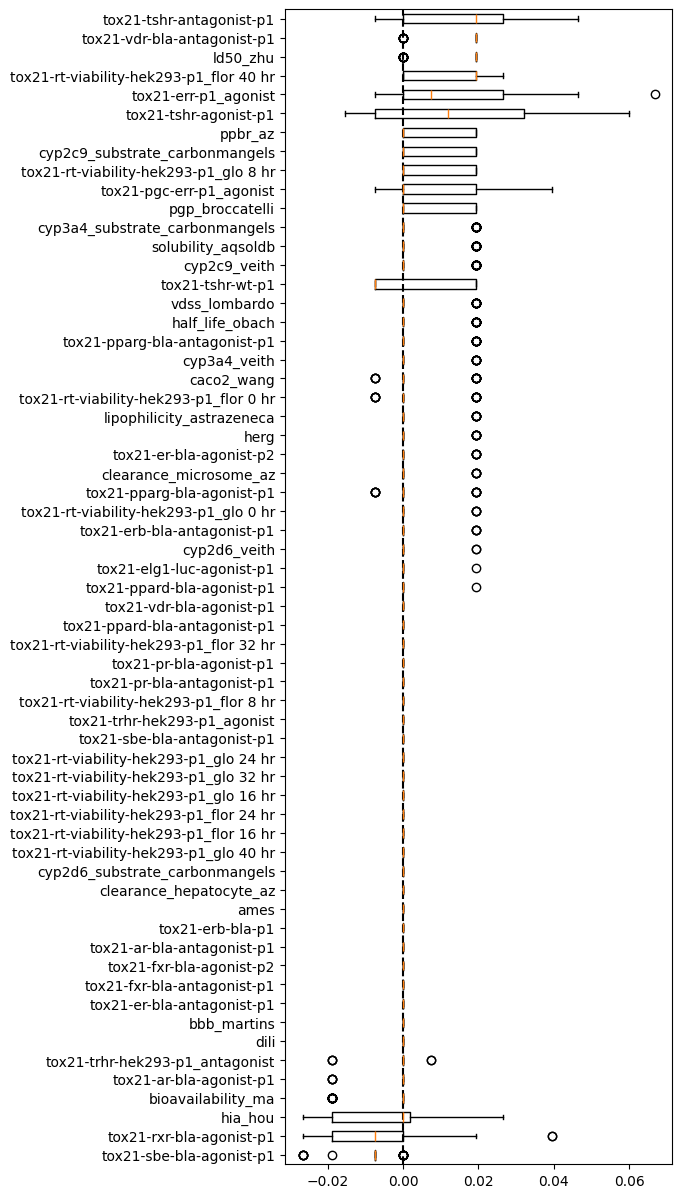

In [136]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (5,15))
_ = plot_permutation_importance(gnb, X_test, y_test, ax)
#print(print(f"Baseline accuracy on test data: {gnb.score(X_train, y_train):.2}"))

Text(0.5, 0, '$\\longleftarrow$ Importance')

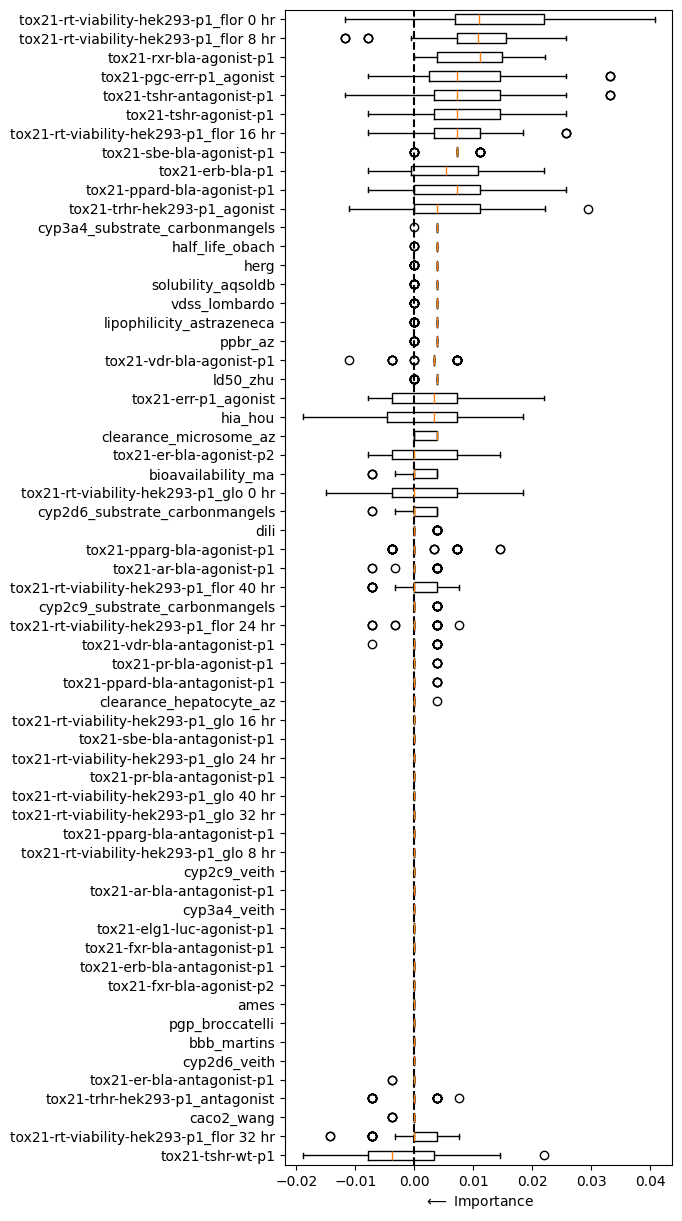

In [137]:
fig, ax = plt.subplots(figsize = (5, 15))
_ = plot_permutation_importance(gnb, X_train, y_train, ax)
ax.set_xlabel(r'$\longleftarrow$ Importance')

Text(0.5, 4.444444444444445, '$\\longleftarrow$ Importance')